In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

src = cv2.imread('smarties.png')

In [2]:
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)
    
rows = gray.shape[0]
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows / 8,
                               param1 = 100, param2 = 30,
                               minRadius = 1, maxRadius = 30)
circles = np.uint16(np.around(circles))

# trabalhando com o objeto 'circles' (contém: coordenadas x, y e raio)

src = cv2.imread('smarties.png') # lendo a imagem novamente, para obter as cores (acessando coordenadas)

info = [[ (i[2] ** 2) * np.pi] for i in circles[0]] # base(dados que serão utilizados em dataframe)

coords_aux = [[i[0], i[1]] for i in circles[0]] # aux
scls_aux = [src[i[1]][i[0]].tolist() for i in coords_aux] # aux
                        # passaremos estesa valores no kmeans, este nos retonará os clusters de cada tupla rgb, 
                        # 'apendaremos' o retorno na lista de listas 'info'
for n in range(len(info)):
    for i in scls_aux[n]:
        info[n].append(i)

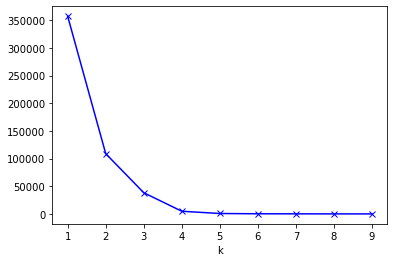

In [3]:
# buscando pelo melhor número de clusters para um kmeans, que indentificará quantas cores de doces existem

X = pd.DataFrame([i for i in scls_aux])
distortions = []
K = range(1,10)
for k in K:
    kmns = KMeans(n_clusters = k)
    kmns.fit(X)
    distortions.append(kmns.inertia_)
plt.figure(figsize = (6, 4))   
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.show()

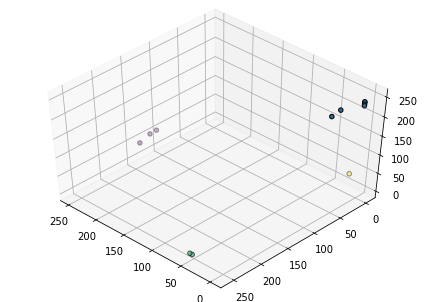

In [4]:
# ajustando kmeans para o número ideal de clusters, de acordo com o elbow plot

optimal_k = 4

X = pd.DataFrame([i for i in scls_aux])

kmns = KMeans(n_clusters = optimal_k)
fig = plt.figure(figsize = (6, 4))
ax = Axes3D(fig, rect = [0, 0, .95, 1], elev = 48, azim = 134)
kmns.fit(X)
labels = kmns.labels_
ax.scatter(X[0], X[1], X[2], c = labels.astype(np.float), edgecolor = 'k')
plt.show()

In [5]:
clusters = kmns.predict(scls_aux).tolist()
# juntar 'clusters' a 'info', então 'info' estará pronta para ser transformada em um dataframe
for n in range(len(info)):
    info[n].append(clusters[n])
    
df = pd.DataFrame(info, columns = ['area', 'r', 'g', 'b', 'cluster'])

In [6]:
df

,area,r,g,b,cluster
0,2290.221044,247,143,52,0
1,2290.221044,247,112,63,0
2,2463.008640,247,124,62,0
3,2290.221044,0,61,248,1
4,2123.716634,48,255,0,2
5,2290.221044,0,0,238,1
6,2123.716634,52,255,0,2
7,2123.716634,0,0,239,1
8,2463.008640,0,0,233,1
9,2290.221044,0,45,252,1


In [7]:
# estabelecendo uma tupla rgb para cada cluster (tirando as médias de cada canal, para cada cluster)
# ex: estabeleceremos que doces do cluster '0' possuem cor (0.0, 17.666667, 239.833333)
df_color_tuples = df.groupby('cluster').mean()[['r', 'g', 'b']]
df_color_tuples = df_color_tuples.apply(lambda x: round(x)).astype(int)
df_color_tuples

,r,g,b
cluster,,,
0,247,126,59
1,0,18,240
2,50,255,0
3,11,3,43


In [8]:
# buscando por cores para estas tuplas:

# busca manual em: 'https://www.rapidtables.com/web/color/RGB_Color.html'
# a busca traz um 'nome' para cada cor, com base em uma tupla

# azul (0, 18, 240) <- cluster 1
# verde (50, 255, 0) <- cluster 0
# laranja(247, 12, 59) <- cluster 2 
# azul escuro (11, 3, 43) <- cluster 3 

labels = {0 : 'verde', 1 : 'azul', 2 : 'laranja', 3 : 'azul_escuro'}

In [9]:
# aplicando labels aos clusters
def label_clusters(x, labels):
    for n in labels:
        if x == n:
            return labels[n]

df['cluster_label'] = df['cluster'].apply(lambda x: label_clusters(x, labels))
df.drop(columns = ['r', 'g', 'b', 'cluster'], inplace = True)

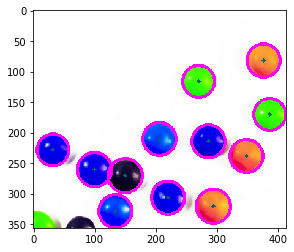

area                  
                      mean         std count
cluster_label                               
azul           2291.268242  107.305817     6
azul_escuro    2463.008640         NaN     1
laranja        2123.716634    0.000000     2
verde          2347.816910   99.758965     3

In [10]:
for i in circles[0, :]:
    center = (i[0], i[1])
    cv2.circle(src, center, 1, (0, 100, 100), 3)
    radius = i[2]
    cv2.circle(src, center, radius, (255, 0, 255), 3)
    
plt.imshow(src)
plt.show()

# qual a área média dos doces de cada cor?
# qual o desvio padrão de área entre doces de cada cor?
# quantos doces de cada cor?

df.groupby('cluster_label').agg(['mean', 'std', 'count'])